In [26]:
import pandas as pd

In [27]:
df = pd.read_csv("../PerformanceEvolution_Website/PerformanceEvolution_Data/MySQL/measurements.csv", delimiter=";")

In [28]:
version_counts = df['revision'].value_counts().reset_index()
version_counts.columns = ['revision', 'count']
print(version_counts)

   revision  count
0    5.6.10    972
1    5.6.13    972
2    8.0.15    972
3    8.0.13    972
4    8.0.12    972
5    5.7.22    972
6    5.7.21    972
7    5.7.20    972
8    5.7.18    972
9    5.7.17    972
10   5.7.14    972
11   5.7.11    972
12    5.7.9    972
13   5.6.26    972
14   5.6.24    972
15   5.6.22    972
16   5.6.20    972
17   5.6.17    972
18   5.6.15    972
19   8.0.17    972


In [29]:
from sklearn import ensemble, linear_model, tree, neighbors, svm
from sklearn.model_selection import train_test_split

specific_version = '5.6.10'
df_specific_version = df[df['revision'] == specific_version]

# Step 2: Drop the 'revision' and 'cpu' columns
df_specific_version = df_specific_version.drop(columns=['revision', 'cpu'])

# Step 3: Separate the features (X) and the target variable (y)
X = df_specific_version.drop(columns=['performance'])
y = df_specific_version['performance']

# Step 4: Create the train-test split with train_size = 0.9
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

# Output the shapes of the resulting splits to verify
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (874, 21)
X_test shape: (98, 21)
y_train shape: (874,)
y_test shape: (98,)


In [30]:
gb_reg = ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=12, min_samples_split=100)
lin_reg = linear_model.LinearRegression()
dt_reg = tree.DecisionTreeRegressor(max_depth=12, min_samples_split=100)
rf_reg = ensemble.RandomForestRegressor(n_estimators=100, max_depth=12, min_samples_split=100)
svr_reg = svm.SVR()
knn_reg = neighbors.KNeighborsRegressor(n_neighbors=5)

# Train the models
models = {
    'Gradient Boosting': gb_reg,
    'Linear Regression': lin_reg,
    'Decision Tree': dt_reg,
    'Random Forest': rf_reg,
    'Support Vector Regressor': svr_reg,
    'K-Nearest Neighbors': knn_reg
}

for model_name, model in models.items():
    model.fit(X_train, y_train)

In [31]:
results = {model_name: [] for model_name in models}

other_versions = df[df['revision'] != specific_version]['revision'].unique()

for version in other_versions:
    df_version = df[df['revision'] == version].drop(columns=['revision', 'cpu'])
    X_version = df_version.drop(columns=['performance'])
    y_version = df_version['performance']
    
    for model_name, model in models.items():
        y_pred_version = model.predict(X_version)
        dfErrorsVersion = pd.DataFrame({"% error":((y_pred_version - y_version)/y_version).abs()*100})
        error_version = dfErrorsVersion["% error"].mean()
        results[model_name].append((version, error_version))
        print(f"MAPE for {model_name} on {version} : {error_version}")

# Convert results to DataFrames for plotting
df_results = {model_name: pd.DataFrame(result, columns=['Version', 'MAPE']) for model_name, result in results.items()}


MAPE for Gradient Boosting on 5.6.13 : 3.252987597423882
MAPE for Linear Regression on 5.6.13 : 16.43640706273657
MAPE for Decision Tree on 5.6.13 : 3.4727715070771166
MAPE for Random Forest on 5.6.13 : 3.6041823966234126
MAPE for Support Vector Regressor on 5.6.13 : 16.35259392631196
MAPE for K-Nearest Neighbors on 5.6.13 : 14.312636667086425
MAPE for Gradient Boosting on 5.6.15 : 3.55714297233058
MAPE for Linear Regression on 5.6.15 : 15.95089769221195
MAPE for Decision Tree on 5.6.15 : 3.7277910827815153
MAPE for Random Forest on 5.6.15 : 3.799633638229159
MAPE for Support Vector Regressor on 5.6.15 : 15.647493532548154
MAPE for K-Nearest Neighbors on 5.6.15 : 13.728839465698167
MAPE for Gradient Boosting on 5.6.17 : 3.5884608513920537
MAPE for Linear Regression on 5.6.17 : 16.24484939582721
MAPE for Decision Tree on 5.6.17 : 3.839022727053288
MAPE for Random Forest on 5.6.17 : 3.9168195642050994
MAPE for Support Vector Regressor on 5.6.17 : 16.47078464315304
MAPE for K-Nearest Neig

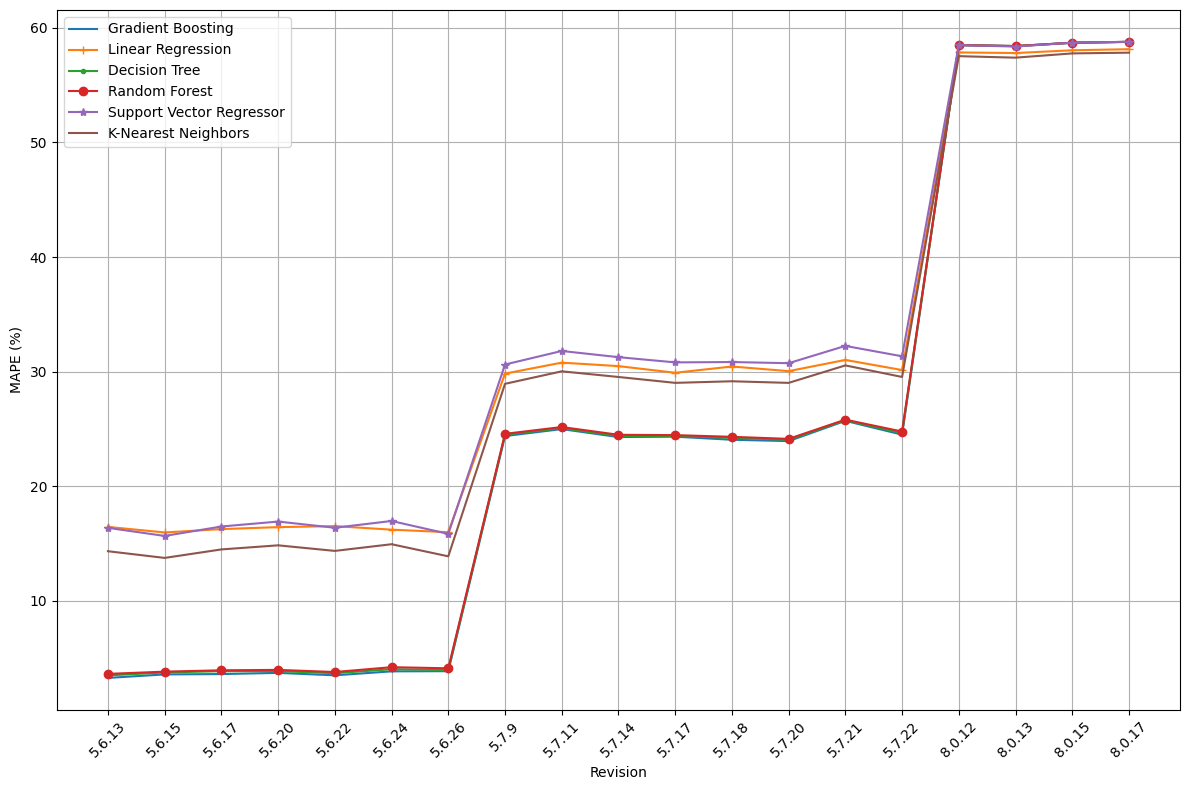

In [32]:
import matplotlib.pyplot as plt
import itertools
marker = itertools.cycle((',', '+', '.', 'o', '*')) 

plt.figure(figsize=(12, 8))

for model_name, df_result in df_results.items():
    plt.plot(df_result['Version'], df_result['MAPE'], marker=next(marker), linestyle='-', label=model_name)

plt.xlabel('Revision')
plt.ylabel('MAPE (%)')
# plt.title('MAPE by Revision for Different Models [MySQL]')
plt.title('')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
revisions = sorted(other_versions)
summary_df = pd.DataFrame(index=revisions)

# Populate the summary DataFrame with MAPE scores
for model_name, df_result in df_results.items():
    df_result.set_index('Version', inplace=True)
    summary_df[model_name] = df_result['MAPE']

print(summary_df)

        Gradient Boosting  Linear Regression  Decision Tree  Random Forest  \
5.6.13           3.252988          16.436407       3.472772       3.610012   
5.6.15           3.557143          15.950898       3.727791       3.808185   
5.6.17           3.588461          16.244849       3.839023       3.921152   
5.6.20           3.690853          16.415460       3.843552       3.959903   
5.6.22           3.478446          16.505013       3.665085       3.771750   
5.6.24           3.825362          16.196299       4.010430       4.195191   
5.6.26           3.840252          15.970939       3.951983       4.106280   
5.7.11          24.976668          30.778339      25.061236      25.153856   
5.7.14          24.280592          30.473380      24.371175      24.479605   
5.7.17          24.313329          29.894004      24.376629      24.442768   
5.7.18          24.044886          30.440104      24.208525      24.304999   
5.7.20          23.927339          30.035426      24.038876     

In [22]:
def is_lower_version(version1, version2):
    # Split the version strings into components
    v1_components = list(map(int, version1.split('.')))
    v2_components = list(map(int, version2.split('.')))

    # Compare the components sequentially
    for v1, v2 in zip(v1_components, v2_components):
        if v1 < v2:
            return True
        elif v1 > v2:
            return False

    # If all components are equal, the versions are considered equal
    return False

removing 0 for 5.6.13 against 5.6.13
[None, 46.459767333444994, 142.908843732186]
removing 1 for 5.7.9 against 5.6.13
[None, None, 142.908843732186]
removing 2 for 8.0.12 against 5.6.13
[None, None, None]
MAPE for model trained on 5.6.13 evaluated on 5.6.13 data: 3.105582973141133
removing 1 for 5.7.9 against 5.6.15
[3.124599635380255, None, 142.00735484877626]
removing 2 for 8.0.12 against 5.6.15
[3.124599635380255, None, None]
MAPE for model trained on 5.6.15 evaluated on 5.6.15 data: 3.0397227905562874
removing 1 for 5.7.9 against 5.6.17
[2.9215151528580483, None, 143.4817542057416]
removing 2 for 8.0.12 against 5.6.17
[2.9215151528580483, None, None]
MAPE for model trained on 5.6.17 evaluated on 5.6.17 data: 2.9932297746116885
removing 1 for 5.7.9 against 5.6.20
[3.7975973045862736, None, 142.29153702569167]
removing 2 for 8.0.12 against 5.6.20
[3.7975973045862736, None, None]
MAPE for model trained on 5.6.20 evaluated on 5.6.20 data: 3.5360120180188024
removing 1 for 5.7.9 against

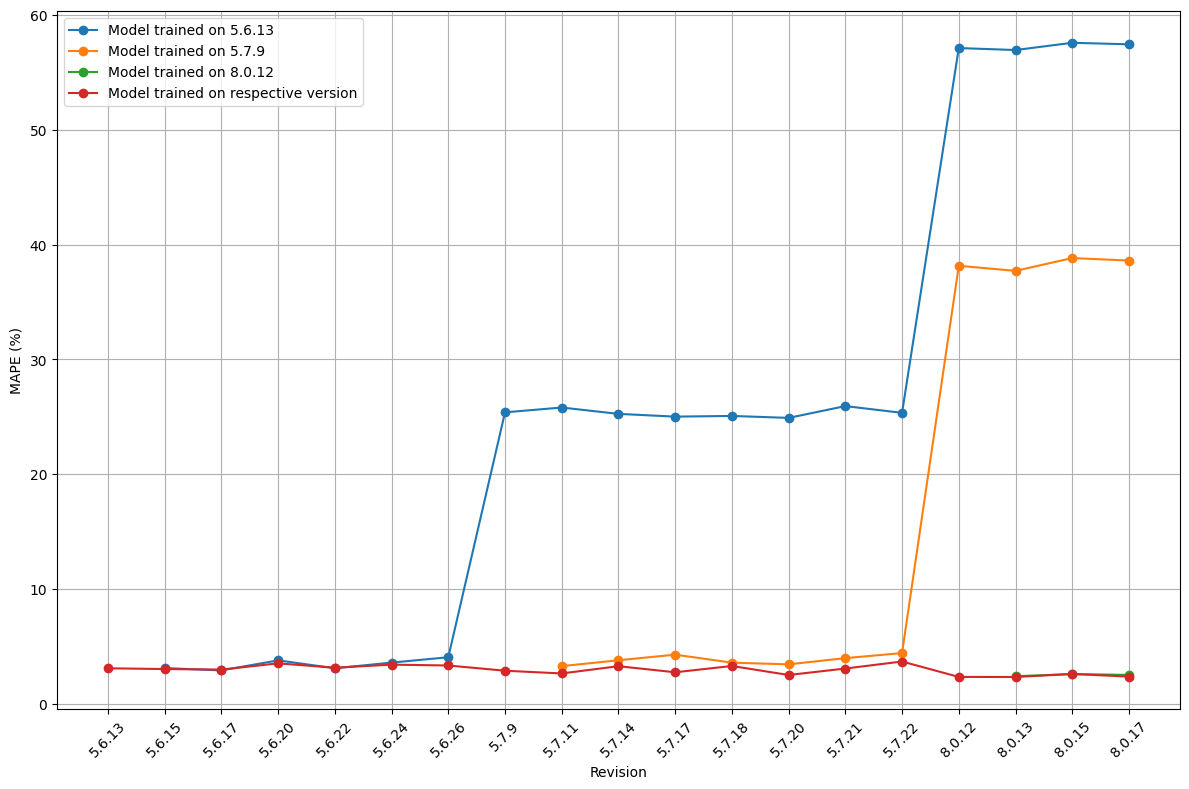

In [24]:
earliest_revision = specific_version
df_earliest_revision = df[df['revision'] == earliest_revision].drop(columns=['revision', 'cpu'])
X_earliest = df_earliest_revision.drop(columns=['performance'])
y_earliest = df_earliest_revision['performance']

X_train_earliest, X_test_earliest, y_train_earliest, y_test_earliest = train_test_split(X_earliest, y_earliest, train_size=0.9, random_state=42)

# Initialize and train the model on the baseline revisions
baseline_revisions = ['5.6.13', 
                      #'5.7.21',
                    '5.7.9', '8.0.12']

# Initialize a dictionary to store the trained models
baseline_models = {}

# Train models on the baseline revisions
for revision in baseline_revisions:
    df_baseline_revision = df[df['revision'] == revision].drop(columns=['revision', 'cpu'])
    X_baseline = df_baseline_revision.drop(columns=['performance'])
    y_baseline = df_baseline_revision['performance']
    
    X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(X_baseline, y_baseline, train_size=0.9, random_state=42)
    
    # Initialize and train the model
    gb_model = ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=12, min_samples_split=100)
    gb_model.fit(X_train_baseline, y_train_baseline)
    
    baseline_models[revision] = gb_model

#gb_model_earliest = ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=12, min_samples_split=100)
#gb_model_earliest.fit(X_train_earliest, y_train_earliest)

# Step 2: Train separate Gradient Boosting models on each of the other revisions
other_versions = df[df['revision'] != earliest_revision]['revision'].unique()

results = []

for version in other_versions:
    df_version = df[df['revision'] == version].drop(columns=['revision', 'cpu'])
    X_version = df_version.drop(columns=['performance'])
    y_version = df_version['performance']
    
    X_train_version, X_test_version, y_train_version, y_test_version = train_test_split(X_version, y_version, train_size=0.9, random_state=42)
    
    # Train a model on the current version
    gb_model_version = ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=12, min_samples_split=100)
    gb_model_version.fit(X_train_version, y_train_version)
    
    # Evaluate both models on the current version's test data
    baseline_y_pred_on_version = [baseline_models[model].predict(X_test_version) for model in baseline_models]
    #y_pred_earliest_on_version = gb_model_earliest.predict(X_test_version)
    y_pred_version_on_version = gb_model_version.predict(X_test_version)
    
    #dfErrorsEarliest = pd.DataFrame({"% error": ((y_pred_earliest_on_version - y_test_version) / y_test_version).abs() * 100})
    
    
    dfErrorsVersion = pd.DataFrame({"% error": ((y_pred_version_on_version - y_test_version) / y_test_version).abs() * 100})
    
    #error_earliest = dfErrorsEarliest["% error"].mean()
    error_version = dfErrorsVersion["% error"].mean()
    
    error_baselines = [pd.DataFrame({"% error": ((pred_on_version - y_test_version) / y_test_version).abs() * 100}) 
                       for pred_on_version in baseline_y_pred_on_version]
    
    error_baselines = [df["% error"].mean() for df in error_baselines]

    for key, model in enumerate(baseline_models):
        if not is_lower_version(model, version):
            print(f"removing {key} for {model} against {version}")
            error_baselines[key] = None
            print(error_baselines)

    results.append((version, error_version, *error_baselines))
    print(f"MAPE for model trained on {version} evaluated on {version} data: {error_version}")

# Convert results to a DataFrame for plotting
column_names = ['Version', 'MAPE_Respective_Model']
column_names.extend([f"MAPE_{r}_Model" for r in baseline_revisions])
df_comparison = pd.DataFrame(results, columns=column_names)

# Plot the results
plt.figure(figsize=(12, 8))

for revision in baseline_revisions:
    column_name = f"MAPE_{revision}_Model"
    print(df_comparison[column_name])
    print(df_comparison['MAPE_Respective_Model'])
    plt.plot(df_comparison['Version'], df_comparison[column_name], marker='o', linestyle='-', label=f'Model trained on {revision}')

plt.plot(df_comparison['Version'], df_comparison['MAPE_Respective_Model'], marker='o', linestyle='-', label='Model trained on respective version')

plt.xlabel('Revision')
plt.ylabel('MAPE (%)')
# plt.title('Model Degradation: Comparing Early Revision Model with Respective Models [MySQL]')
plt.title('')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
df_comparison

Version  MAPE_Respective_Model  MAPE_5.6.13_Model  MAPE_5.7.9_Model  \
0   5.6.13               3.105583                NaN               NaN   
1   5.6.15               3.039723           3.124600               NaN   
2   5.6.17               2.993230           2.921515               NaN   
3   5.6.20               3.536012           3.797597               NaN   
4   5.6.22               3.155537           3.106457               NaN   
5   5.6.24               3.424311           3.601875               NaN   
6   5.6.26               3.348980           4.066704               NaN   
7    5.7.9               2.894230          25.393701               NaN   
8   5.7.11               2.657273          25.814127          3.293572   
9   5.7.14               3.288348          25.260291          3.805479   
10  5.7.17               2.758585          25.021800          4.292457   
11  5.7.18               3.306999          25.080961          3.596943   
12  5.7.20               2.521877          24.910377          3.449762   
13  5.7.21               3.085147          25.938215          3.989970   
14  5.7.22               3.696458          25.349929          4.431545   
15  8.0.12               2.354420          57.117192         38.155689   
16  8.0.13               2.347522          56.944854         37.714551   
17  8.0.15               2.612764          57.576253         38.829358   
18  8.0.17               2.380872          57.444401         38.612913   

    MAPE_8.0.12_Model  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  
5                 NaN  
6                 NaN  
7                 NaN  
8                 NaN  
9                 NaN  
10                NaN  
11                NaN  
12                NaN  
13                NaN  
14                NaN  
15                NaN  
16           2.416986  
17           2.600491  
18           2.529867

To determine the presence of each feature across different revisions and to find the first revision in which each feature appears in your dataset, you can follow these steps:

Iterate through each feature (column) to check if it is present in any instance of each revision.
Create a dictionary to store the first revision each feature appears in.


In [11]:
import pandas as pd

# Assuming df is your dataframe
# Filter out the columns that are not features
feature_columns = [col for col in df.columns if col not in ['revision', 'performance', 'cpu']]

# Initialize a dictionary to store the first revision for each feature
first_revision_presence = {}

# Iterate over each feature
for feature in feature_columns:
    # Get the unique revisions
    revisions = df['revision'].unique()
    for revision in revisions:
        # Filter the dataframe for the current revision
        df_revision = df[df['revision'] == revision]
        # Check if the feature is present in this revision
        if df_revision[feature].any():  # .any() checks if any value in the series is True (i.e., 1)
            # If the feature is present, store the revision and break the loop
            if feature not in first_revision_presence:
                first_revision_presence[feature] = revision
            break

# Convert the dictionary to a dataframe for better readability
df_first_revision_presence = pd.DataFrame(list(first_revision_presence.items()), columns=['Feature', 'First_Present_Revision'])


model shifting

In [41]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

# Assuming df is your dataframe
# Replace 'revision', 'performance', and 'cpu' with the actual column names

# Step 1: Train a model on the dataset for revision R1
def train_model_on_revision(df, revision, features, target):
    df_r1 = df[df['revision'] == revision]
    X_r1 = df_r1[features]
    y_r1 = df_r1[target]
    model = ensemble.GradientBoostingRegressor(n_estimators=10, max_depth=12, min_samples_split=10)
    model.fit(X_r1, y_r1)
    return model

# Step 2: Create a new dataset for revision R2 and select 100 random rows
def get_sampled_revision(df, revision, sample_size, seed):
    df_r2 = df[df['revision'] == revision]
    sampled_df_r2 = df_r2.sample(n=sample_size, random_state=seed)
    return sampled_df_r2

# Step 3: Use the R1 model to predict the target for R2 and add predictions as a new feature
def add_predictions_as_feature(df, model, features):
    df['R1_predictions'] = model.predict(df[features])
    return df

# Step 4: Train a new model on the enhanced R2 dataset
def train_new_model_on_enhanced_revision(df, features, target):
    X = df[features]
    y = df[target]
    new_model = ensemble.GradientBoostingRegressor(n_estimators=10, max_depth=12, min_samples_split=10)
    new_model.fit(X, y)
    return new_model

# Define features and target
features = [col for col in df.columns if col not in ['revision', 'performance', 'cpu']]
target = 'performance'

# Train the model on R1
revision_R1 = '5.6.26'
model_R1 = train_model_on_revision(df, revision_R1, features, target)

# Create the enhanced dataset for R2 and train the new model
revision_R2 = '5.7.9'
results = []
for sample_size in [i * 10 for i in range(1, 50)]:
    # sample_size = 100
    sampled_df_R2 = get_sampled_revision(df, revision_R2, sample_size=sample_size, seed=42)
    sampled_df_R2_enhanced = add_predictions_as_feature(sampled_df_R2.copy(), model_R1, features)
    new_model_R2 = train_new_model_on_enhanced_revision(sampled_df_R2_enhanced, features + ['R1_predictions'], target)
    new_model_R2a = train_new_model_on_enhanced_revision(sampled_df_R2, features, target)


    # Evaluate both models on the remaining R2 dataset

    # Exclude the 100 rows used for training the new model
    remaining_df_R2 = df[(df['revision'] == revision_R2) & (~df.index.isin(sampled_df_R2.index))]

    # Features and target for the remaining R2 dataset
    X_remaining_R2 = remaining_df_R2[features]
    y_remaining_R2 = remaining_df_R2[target]

    # Predictions using the R1 model
    y_pred_R1 = model_R1.predict(X_remaining_R2)

    # Add R1 predictions as a feature in the remaining R2 dataset
    X_remaining_R2_enhanced = X_remaining_R2.copy()
    X_remaining_R2_enhanced['R1_predictions'] = y_pred_R1

    # Predictions using the R2 model
    y_pred_R2 = new_model_R2.predict(X_remaining_R2_enhanced)
    y_pred_R2a = new_model_R2a.predict(X_remaining_R2)

    # Calculate MAPE for both models
    mape_R1 = mean_absolute_percentage_error(y_remaining_R2, y_pred_R1)
    mape_R2 = mean_absolute_percentage_error(y_remaining_R2, y_pred_R2)
    mape_R2a = mean_absolute_percentage_error(y_remaining_R2, y_pred_R2a)

    print(f"MAPE for {revision_R1} model on {revision_R2} data: {mape_R1:.4f}")
    print(f"MAPE for {revision_R2} model on {revision_R2} data: {mape_R2:.4f}")
    print(f"MAPE for {revision_R2} model (only {revision_R2} data subset) on {revision_R2} data: {mape_R2a:.4f}")
    results.append({
        "sample_size" : sample_size,
        "mape" : mape_R2
    })
    XY_df = X_remaining_R2_enhanced.copy()
    XY_df['r2_pred'] =  y_pred_R2
    XY_df['ground_truth'] =  y_remaining_R2

results_df = pd.DataFrame(results)

results_df.plot(x='sample_size', logx=False,
                title="",legend=False, xlabel="Sample size", ylabel="MAPE"
                )

MAPE for 5.6.26 model on 5.7.9 data: 0.2822
MAPE for 5.7.9 model on 5.7.9 data: 0.3056
MAPE for 5.7.9 model (only 5.7.9 data subset) on 5.7.9 data: 0.3107
MAPE for 5.6.26 model on 5.7.9 data: 0.2821
MAPE for 5.7.9 model on 5.7.9 data: 0.1817
MAPE for 5.7.9 model (only 5.7.9 data subset) on 5.7.9 data: 0.2823
MAPE for 5.6.26 model on 5.7.9 data: 0.2817
MAPE for 5.7.9 model on 5.7.9 data: 0.1730
MAPE for 5.7.9 model (only 5.7.9 data subset) on 5.7.9 data: 0.2432
MAPE for 5.6.26 model on 5.7.9 data: 0.2823
MAPE for 5.7.9 model on 5.7.9 data: 0.1628
MAPE for 5.7.9 model (only 5.7.9 data subset) on 5.7.9 data: 0.2331
MAPE for 5.6.26 model on 5.7.9 data: 0.2819
MAPE for 5.7.9 model on 5.7.9 data: 0.1523
MAPE for 5.7.9 model (only 5.7.9 data subset) on 5.7.9 data: 0.2053
MAPE for 5.6.26 model on 5.7.9 data: 0.2823
MAPE for 5.7.9 model on 5.7.9 data: 0.1458
MAPE for 5.7.9 model (only 5.7.9 data subset) on 5.7.9 data: 0.1587
MAPE for 5.6.26 model on 5.7.9 data: 0.2817
MAPE for 5.7.9 model on 5.

<Axes: xlabel='Sample size', ylabel='MAPE'>